# Stroke Prediction

### INTRODUCTION

Strokes occurs when the blood vessel supplying the brain ruptures, becomes blocked, or reduced. It deprives the neurons and brain cells of oxygen and nutrients, leading to cell death. 

In Canada
Stroke is the leading cause of adult disability and the third leading cause of death. 
14,000 Canadians die from stroke every year


Goal: The goal of this project is to build a model to predict the probability of having a stroke based on physical, medical and social variables, such as age, comorbidities and smoking status.


Used database: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset.

This dataset is comprised of 5110 rows corresponding to patients and the following columns:

- id : unique identifier
- gender : "Male", "Female" or "Other"
- age : age of the patient
- hypertension : 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart_disease : 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married : "No" or "Yes"
- work_type : "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type : "Rural" or "Urban"
- avg_glucose_level : average glucose level in blood
- bmi : body mass index
- smoking_status : "formerly smoked", "never smoked", "smokes" or "Unknown"
- stroke : 0 the patient did not have a stroke, and 1 if the patient had a stroke

### WHY STROKE PREDICTION IS IMPORTANT

Over 10 million people worldwide die or are permanently disabled yearly from a stroke. It’s a problem that places a significant demand on the healthcare system, as there are few reliable biomarkers to help physicians to identify patients who will suffer from it. Delays in stroke prediction can cause patients to lose over 2 million cells due to interrupted blood flow to the brain, and an earlier diagnosis can mean faster treatment and a decrease in severe outcomes.               Due to technological advancements, taking a predictive approach to preventing a stroke and identifying its severity has become more feasible, where models have empowered physicians and first responders to identify signs of stroke quicker and more confidently. In a 2017 trial, researchers developed machine learning models and used natural language processing algorithms that predicted more accurately than physicians which patients will suffer a stroke within a decade. Researchers often use neuroimaging techniques like Magnetic Resonance Imaging (MRI) or Computed Tomography (CT) scans to identify a stroke. Assistive AI tools are also being created to retroactively analyze neurological symptoms, to offer insight into the biomarkers that may correlate with the occurrence of stroke.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
# load the data 
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


------------------------------------------------------------------------------------------------------------------

## EDA

In [4]:
# shape of the dataset
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print(f"Missing values: {df.isna().sum().sum()}")

Rows: 5110
Columns: 12
Missing values: 201


In [5]:
# general info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


------------------------------------------------------------------------------------------------------------------

### Checking if the dataset stroke class distribution of stroke vs non-stroke 

In [6]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

The valus above indicate that the dataset is very imbalanced dataset, where the stroke category only accounts for 5% of the dataset. This can be very problematic because it could lead high model accuracy just by predicting the majority class, but you fail to capture the minority class.

------------------------------------------------------------------------------------------------------------------

### Adressing Missing Values

In [7]:
# checking for missing values + where they located
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
# to find the percentage of the missing values
df.isna().sum()/len(df)

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  0.039335
smoking_status       0.000000
stroke               0.000000
dtype: float64

Text(0.5, 1.0, 'Missing values')

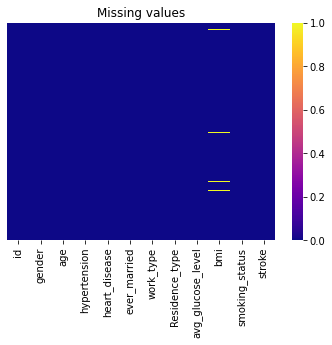

In [9]:
# visualizing missing values
sns.heatmap(df.isnull(), yticklabels = False, cmap= "plasma")
plt.title('Missing values')

As seen above, there are 201 NaN values, and all from the BMI column. We have a couple of options to address the missing values, but for our case, since we know that from medical literature is not dependent on sex or age, and our dataset is quite imbalanced, it would not be accurate to predict the BMI based on the available variables. Therefore, we will fill the missing values with the BMI average. 

In [10]:
# filling the missing values (BMI) with the mean of the column
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [11]:
# sanity check
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

------------------------------------------------------------------------------------------------------------------

##  Preprocessing + continued EDA

In [12]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### BMI

Text(0.5, 1.0, 'BMI x Stroke')

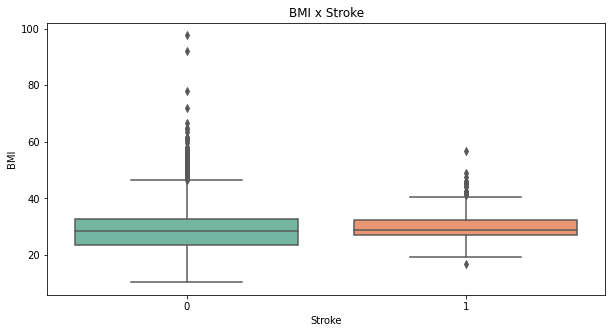

In [13]:
# Creating the visualization
bmi_fig = plt.subplots(figsize=(10,5))
bmi_fig = sns.boxplot(x='stroke', y='bmi', data=df, palette="Set2")
bmi_fig.set_xlabel('Stroke')
bmi_fig.set_ylabel('BMI')
bmi_fig.set_title('BMI x Stroke')

The visualization above shows how BMI does not seem to impact the incidence of strokes

### Age

As per the dataset description avove, the minimum age is <1 year old, and the maxium age is 82 years old

In [14]:
# create empty column for age_group
df['age group'] = ''
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,


In [15]:
# create age groups to fill up that column

df.loc[(df.age <= 5),  'age group'] = '0-05'
df.loc[(df.age >= 6) & (df.age <= 10),  'age group'] = '06-10'
df.loc[(df.age >= 11) & (df.age <= 20),  'age group'] = '11-20'
df.loc[(df.age >= 20) & (df.age <= 30),  'age group'] = '21-30'
df.loc[(df.age >= 30) & (df.age <= 40),  'age group'] = '31-40'
df.loc[(df.age >= 40) & (df.age <= 50),  'age group'] = '41-50'
df.loc[(df.age >= 50) & (df.age <= 60),  'age group'] = '51-60'
df.loc[(df.age >= 60) & (df.age <= 70),  'age group'] = '61-70'
df.loc[(df.age >= 70) & (df.age <= 80),  'age group'] = '71-80'
df.loc[(df.age >= 80) & (df.age <= 90),  'age group'] = '81-90'
df.loc[(df.age >= 90) & (df.age <= 100),  'age group'] = '91-100'

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,61-70
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,61-70
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,81-90
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,41-50
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,71-80


Text(0.5, 1.0, 'Stroke incidence by age group')

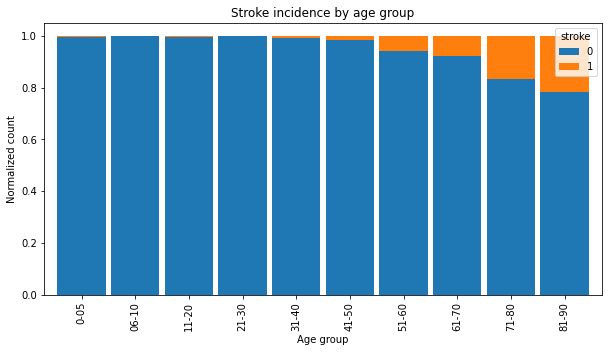

In [16]:
# visualizing age groups and their relationship with stroke
df.groupby('age group')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (10,5), width = 0.9)
plt.xlabel("Age group")
plt.ylabel("Normalized count")
plt.title('Stroke incidence by age group')

The visualizations above demonstrate that older patients suffer more strokes than younger patients.

### Ever married

In [17]:
# checking ever_married class distribution
df['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [18]:
# convert the ever married column to binary
df['ever_married'] = df['ever_married'].map({'Yes':1,'No':0})

In [19]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age group
0,9046,Male,67.0,0,1,1,Private,Urban,228.69,36.600000,formerly smoked,1,61-70
1,51676,Female,61.0,0,0,1,Self-employed,Rural,202.21,28.893237,never smoked,1,61-70
2,31112,Male,80.0,0,1,1,Private,Rural,105.92,32.500000,never smoked,1,81-90
3,60182,Female,49.0,0,0,1,Private,Urban,171.23,34.400000,smokes,1,41-50
4,1665,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,never smoked,1,71-80


Text(0.5, 1.0, 'Stroke x Ever married')

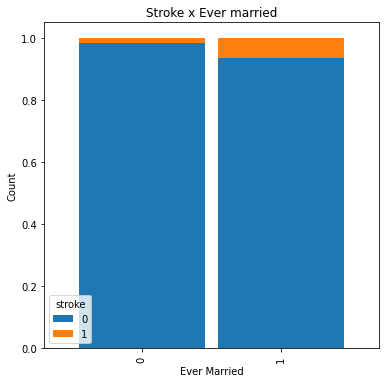

In [20]:
# visualizing ever married and their relationship with stroke
df.groupby('ever_married')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Ever Married")
plt.ylabel("Count")
plt.title('Stroke x Ever married')

Marital status does seem to have an influence on stroke, but since marital status is highly correlated with age (as we will see later on in this notebook), and stroke is more likely to occur with older individuals, we can disregard that marital status increases the chance of stroke.

### Gender

In [21]:
# checking gender class distribution
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

We can see that we only have one patient with gender = 'other'. Since we can't make any inferences with n = 1, we can drop this row.

In [22]:
# drop the row where the gender is "Other", since there is only one data point with that classification
df.drop( df[ df['gender'] == 'Other' ].index, inplace=True)

In [23]:
# convert the gender categorical variables to binary
df['gender'] = df['gender'].map({'Female':1,'Male':0})

In [24]:
df['gender'].value_counts()

1    2994
0    2115
Name: gender, dtype: int64

Text(0.5, 1.0, 'Stroke x Gender')

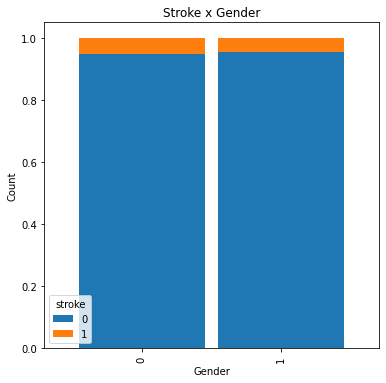

In [25]:
# visualizing gender and their relationship with stroke
df.groupby('gender')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title('Stroke x Gender')

Gender does not seem to have a significant impact on stroke.
The viusalization above shows that males have a slight higher probability of having a stroke but that difference is not significant

### Residence type

In [26]:
# checking residence type class distribution
df['Residence_type'].value_counts()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

In [27]:
# convert the residence type categorical variables to binary
df['Residence_type'] = df['Residence_type'].map({'Urban':1,'Rural':0})

In [28]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age group
0,9046,0,67.0,0,1,1,Private,1,228.69,36.600000,formerly smoked,1,61-70
1,51676,1,61.0,0,0,1,Self-employed,0,202.21,28.893237,never smoked,1,61-70
2,31112,0,80.0,0,1,1,Private,0,105.92,32.500000,never smoked,1,81-90
3,60182,1,49.0,0,0,1,Private,1,171.23,34.400000,smokes,1,41-50
4,1665,1,79.0,1,0,1,Self-employed,0,174.12,24.000000,never smoked,1,71-80


Text(0.5, 1.0, 'Incidence of stroke x residence type')

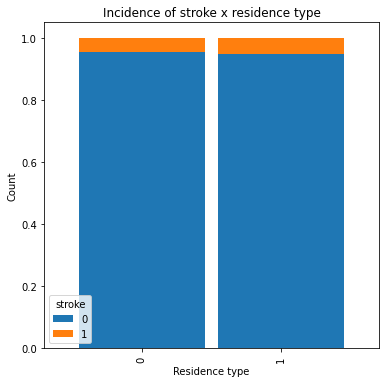

In [29]:
# visualizing residence type and their relationship with stroke
df.groupby('Residence_type')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Residence type")
plt.ylabel("Count")
plt.title('Incidence of stroke x residence type')

Residence type does not seem to have a significant impact on stroke.
The viusalization abover shows that patients who live urban areas have a slight higher more likely to have a stroke but that difference is not significant

### Hypertension

Text(0.5, 1.0, 'Stroke x Hypertension')

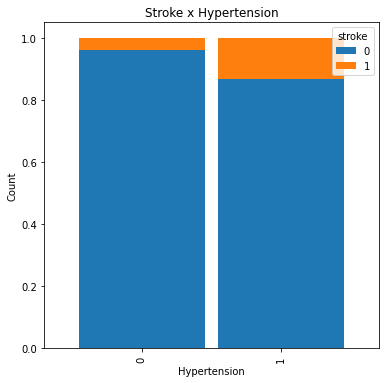

In [30]:
# visualizing hypertension and its relationship with stroke
df.groupby('hypertension')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Hypertension")
plt.ylabel("Count")
plt.title('Stroke x Hypertension')

### Heart Disease

Text(0.5, 1.0, 'Stroke x Heart disease')

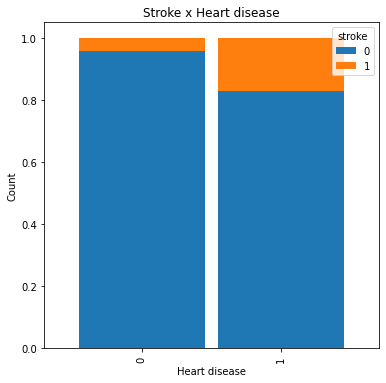

In [31]:
# visualizing heart disease and its relationship with stroke
df.groupby('heart_disease')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Heart disease")
plt.ylabel("Count")
plt.title('Stroke x Heart disease')

### Average Glucose levels

Text(0.5, 1.0, 'Stroke x average glucose level')

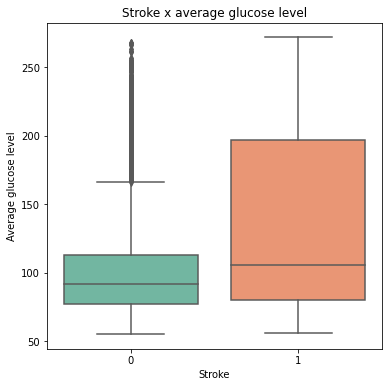

In [32]:
# To create the figure and setting the dimensions
fig, ax = plt.subplots(figsize=(6,6))

# To create the boxplot for stroke and BMI
ax = sns.boxplot(x='stroke', y='avg_glucose_level', data=df, palette = 'Set2')
ax.set_xlabel('Stroke')
ax.set_ylabel('Average glucose level')
ax.set_title('Stroke x average glucose level')

Patient who have either Hypertension, Heart disease and high glucose levels are more likely to have a stroke

### Work type and Smoking status

In [33]:
df2 = df.copy()

In [34]:
# checking work type class distribution
df['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Text(0.5, 1.0, 'Stroke x smoking status')

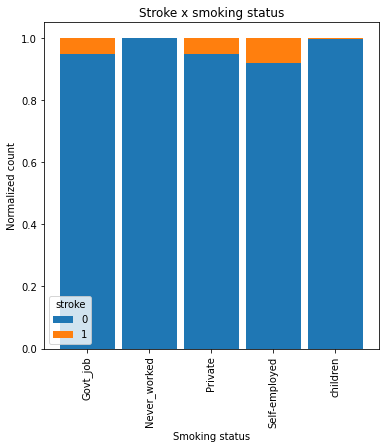

In [35]:
# visualizing work type and its relationship with stroke
df.groupby('work_type')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Smoking status")
plt.ylabel("Normalized count")
plt.title('Stroke x smoking status')

In [36]:
# checking smoking status class distribution
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

Text(0.5, 1.0, 'Stroke x smoking status')

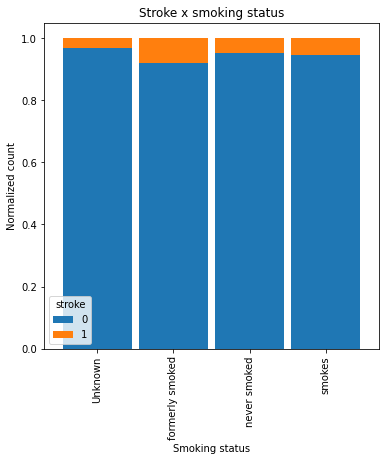

In [37]:
# visualizing smoking status and its relationship with stroke
df.groupby('smoking_status')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Smoking status")
plt.ylabel("Normalized count")
plt.title('Stroke x smoking status')

Before starting the modelling process to predict stroke occurrence, we need to convert our categorical variables to numerical inputs. For this dataset, I used the OneHot Encoding method, which is used when there is no inherent order to the categories. It takes the categorical data and transforms it into columns of binary 0/1 data, one column for each of the unique category values (thus increasing the number of columns we initially had).

In [38]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
subcategory = df[['work_type', 'smoking_status']]
encoded = ohe.fit_transform(subcategory)
encoded

<5109x9 sparse matrix of type '<class 'numpy.float64'>'
	with 10218 stored elements in Compressed Sparse Row format>

In [39]:
subcategory.head()

,work_type,smoking_status
0,Private,formerly smoked
1,Self-employed,never smoked
2,Private,never smoked
3,Private,smokes
4,Self-employed,never smoked


In [40]:
dense_array = encoded.toarray()
dense_array

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [41]:
ohe.categories_

[array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
       dtype=object),
 array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
       dtype=object)]

In [42]:
new_columns= ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children', 'Unknown', 'formerly smoked', 'never smoked', 'smokes']

In [43]:
# Put into a dataframe to get column names
encoded_df = pd.DataFrame(dense_array, columns=new_columns, dtype=int)

# Show
encoded_df.head()

,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes
0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0


In [44]:
ohe.categories_[0]

array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
      dtype=object)

In [45]:
#merge both dataframes
df_merged = pd.concat([df, encoded_df], axis=1)

In [46]:
# double checking the merged dataframes
df_merged.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,age group,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes
0,9046.0,0.0,67.0,0.0,1.0,1.0,Private,1.0,228.69,36.600000,...,61-70,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,51676.0,1.0,61.0,0.0,0.0,1.0,Self-employed,0.0,202.21,28.893237,...,61-70,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,31112.0,0.0,80.0,0.0,1.0,1.0,Private,0.0,105.92,32.500000,...,81-90,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60182.0,1.0,49.0,0.0,0.0,1.0,Private,1.0,171.23,34.400000,...,41-50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1665.0,1.0,79.0,1.0,0.0,1.0,Self-employed,0.0,174.12,24.000000,...,71-80,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [47]:
df_merged.drop('work_type', axis=1, inplace=True)

In [48]:
df_merged.drop('smoking_status', axis=1, inplace=True)

In [49]:
df_merged.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,age group,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes
0,9046.0,0.0,67.0,0.0,1.0,1.0,1.0,228.69,36.600000,1.0,61-70,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,51676.0,1.0,61.0,0.0,0.0,1.0,0.0,202.21,28.893237,1.0,61-70,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,31112.0,0.0,80.0,0.0,1.0,1.0,0.0,105.92,32.500000,1.0,81-90,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60182.0,1.0,49.0,0.0,0.0,1.0,1.0,171.23,34.400000,1.0,41-50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1665.0,1.0,79.0,1.0,0.0,1.0,0.0,174.12,24.000000,1.0,71-80,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [50]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 3116
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   float64
 1   gender             5109 non-null   float64
 2   age                5109 non-null   float64
 3   hypertension       5109 non-null   float64
 4   heart_disease      5109 non-null   float64
 5   ever_married       5109 non-null   float64
 6   Residence_type     5109 non-null   float64
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   stroke             5109 non-null   float64
 10  age group          5109 non-null   object 
 11  Govt_job           5109 non-null   float64
 12  Never_worked       5109 non-null   float64
 13  Private            5109 non-null   float64
 14  Self-employed      5109 non-null   float64
 15  children           5109 non-null   float64
 16  Unknown            5109 

In [51]:
df_merged.isnull().values.any()

True

In [52]:
df_merged = df_merged[~df_merged.isna().any(axis=1)]

------------------------------------------------------------------------------------------------------------------

### Visualization of the correlation between variables

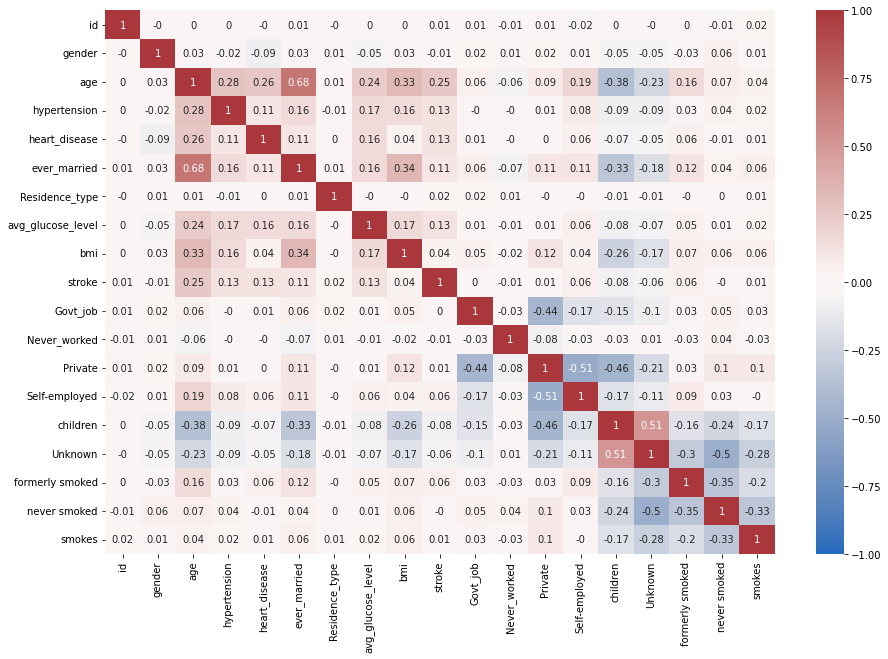

In [53]:
# To create the correlation and plot it as a heatmap
corr = df_merged.corr().round(2)
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot = True, cmap = 'vlag', vmin=-1, vmax=1);

From the heatmap above, we can observe that the "ever_married" and "age" columns have a positive correlation of 0.68, thus the two variables move in the same direction. And since the age colum also influences the probability of a patient to be married, we can drop the "ever_married" column.

------------------------------------------------------------------------------------------------------------------

### Data Preprocessing

The next step in preprocessing is to split the data into Train, Test and Validation. This technique is used to evaluate the performance of the model and prevent overfitting. We fit our model to the training set, evaluate it on the test set, which it has never seen, and provide an unbiased evaluation of the model. 

In [54]:
# setting features and target variables
X = df_merged.drop(columns=["stroke",'id', 'ever_married', 'age group', 'Private'])
y = df_merged["stroke"]

In [55]:
# splitting data into test and train subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [56]:
# splitting data into train and validation subsets *********
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size = 0.75, random_state=1)

In [57]:
# checking dimentions of the test and train subsets
print(X_train.shape, X_test.shape, X_validation.shape)

(3064, 15) (1022, 15) (1022, 15)


In [58]:
# checking dimentions of the test and train subsets
print(y_train.shape, y_test.shape, y_validation.shape)

(3064,) (1022,) (1022,)


In [59]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 3204 to 2406
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1022 non-null   float64
 1   age                1022 non-null   float64
 2   hypertension       1022 non-null   float64
 3   heart_disease      1022 non-null   float64
 4   Residence_type     1022 non-null   float64
 5   avg_glucose_level  1022 non-null   float64
 6   bmi                1022 non-null   float64
 7   Govt_job           1022 non-null   float64
 8   Never_worked       1022 non-null   float64
 9   Self-employed      1022 non-null   float64
 10  children           1022 non-null   float64
 11  Unknown            1022 non-null   float64
 12  formerly smoked    1022 non-null   float64
 13  never smoked       1022 non-null   float64
 14  smokes             1022 non-null   float64
dtypes: float64(15)
memory usage: 127.8 KB


In [60]:
X_validation.describe()

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,Govt_job,Never_worked,Self-employed,children,Unknown,formerly smoked,never smoked,smokes
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,0.590998,42.952329,0.107632,0.061644,0.493151,105.335391,29.288979,0.118395,0.003914,0.168297,0.136986,0.306262,0.154599,0.387476,0.151663
std,0.491890,22.204461,0.310067,0.240625,0.500198,44.472058,7.954164,0.323234,0.062469,0.374313,0.344001,0.461166,0.361699,0.487412,0.358870
min,0.000000,0.560000,0.000000,0.000000,0.000000,55.350000,11.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,76.550000,24.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,43.500000,0.000000,0.000000,0.000000,90.805000,28.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,60.000000,0.000000,0.000000,1.000000,113.725000,33.300000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,271.740000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


------------------------------------------------------------------------------------------------------------------

### Oversampling using SMOTE - to address the imbalanced dataset

To address the imbalanced dataset issue, we could use the approach of resampling where one option would be removing samples from the majority class (under-sampling) or adding more examples from the minority class (over-sampling). In the case of this dataset undersampling would not be a good option since it would reduce the size of the dataset considerably,leading the number of observations in train and test data to be too few to give meaningful performance estimate, and to guide a optimal parameter search.

In this case we will be using the SMOTE Oversampling technique, which used K Nearest Neighbor to oversample the minority class so we can have a better class distribution. This technique will use KNN to synthesize new examples from the existing ones.

In [61]:
counter = Counter(y_train)
print(counter)

Counter({0.0: 2931, 1.0: 133})


In [62]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [63]:
counter = Counter(y_train)
print(counter)

Counter({0.0: 2931, 1.0: 2931})


In [64]:
y_train.shape

(5862,)

------------------------------------------------------------------------------------------------------------------

### Scaling the data 

We need to normalize the variables so they can contribute equally to the model without creating bias. For this dataset, I used Standard Scaler, which tends to perform better for machine learning models. Standard Scaler normalizes the data to be centred around 0 and a standard deviation of 1. For testing purposes, I also imported Min Max Scaler (which subtracts the minimum value of the feature and then divides it by the range, giving us values between 0 and 1), which has a better run-time performance to evaluate during the pipeline.

#### Standard Scaler

In [65]:
scaler = StandardScaler()

In [66]:
# fit to transform X_train
X_train_scaled = scaler.fit_transform(X_train)

# fit to transform X_test
X_test_scaled = scaler.transform(X_test)

# fit to transform X_validation
X_val_scaled = scaler.transform(X_validation)

#### MinMaxScaler

In [67]:
scaler2 = MinMaxScaler()

In [68]:
# fit to transform X_train
X_train_scaled2 = scaler2.fit_transform(X_train)

# fit to transform X_test
X_test_scaled2 = scaler2.transform(X_test)

# fit to transform X_validation
X_val_scaled2 = scaler2.transform(X_validation)

------------------------------------------------------------------------------------------------------------------

# Modelling

### Logistic Regression

Logistic regression: The “go-to” method for classification problems, where we input attributes and with a logistic function it predicts the output a value between 0 and 1 (in our case no stroke or stroke). 

In [69]:
logreg = LogisticRegression()

logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [70]:
# print accuracy for training, validation and test sets

print("Logistic regression:")
print(f"Training accuracy: {logreg.score(X_train_scaled,y_train)}")
print(f"Validation accuracy: {logreg.score(X_val_scaled, y_validation)}")
print(f"Test accuracy: {logreg.score(X_test_scaled, y_test)}")

Logistic regression:
Training accuracy: 0.7809621289662231
Validation accuracy: 0.7602739726027398
Test accuracy: 0.7544031311154599


### Hyperparameter optimization for Logistic regression

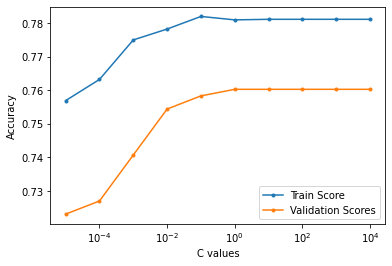

In [71]:
validation_scores = []
train_scores = []

# values of C to iterate over 
#C_values = np.array([.0001,.001,0.1,1,10,100,1000,10000])
C_values = 10.0 **(np.arange(-5, 5))


for C in C_values:
    C_logreg = LogisticRegression(C = C,random_state=1).fit(X_train_scaled,y_train)
    
    # train on traning set
    train_scores.append(C_logreg.score(X_train_scaled,y_train))
    # score on validation set
    validation_scores.append(C_logreg.score(X_val_scaled,y_validation))
    

# C_values accuracy scores
plt.figure()
plt.plot(C_values, train_scores,label="Train Score",marker='.')
plt.plot(C_values, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

### Cross validation on the Logistic regression hyperparameter optimization

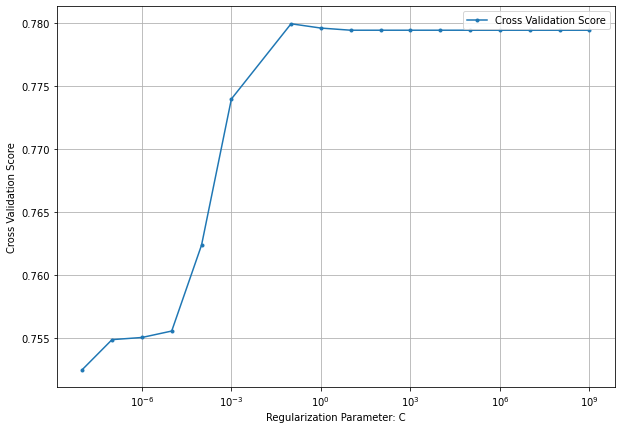

The best model has C =  0.1


In [72]:
cross_validation_scores = []

C_range = C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Do some cross validation
for c in C_range:
                  
    LR_model = LogisticRegression(C=c,random_state=1)
    cv_score = np.mean(cross_val_score(LR_model, X_train_scaled, y_train, cv = 5))
    cross_validation_scores.append(cv_score)

plt.figure(figsize=(10, 7))
plt.plot(C_range, cross_validation_scores,label= "Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ", C_range[which_max])

In [73]:
# refit of the model with the optimal parameters 
final_model = LogisticRegression(C=C_range[which_max])
final_model.fit(X_train_scaled, y_train)

# report the test accuracy
final_model.score(X_test_scaled, y_test)

0.7563600782778865

After normalizing the model to Standard scaler and training the model, our score ended up being 76%. I also completed a hyperparameter optimization and cross-validation for the model, where I used the optimal C value of 10 (identified during the hyperparameter optimization) and confirmed the model score to be 76%.

------------------------------------------------------------------------------------------------------------------

### Naive Bayes

The last model is Naïve Bayes: Unlike all the models above, Naïve Bayes is based on Bayesian statistics, where the model is based on probability rather than distance. For that reason, the model does not require normalization. 

In [74]:
# fit the train datasets in our Naive Bayes analysis
nb_model = GaussianNB()
nb_model.fit(X_train,y_train)

GaussianNB()

In [75]:
# print accuracy for training, validation and test sets - not scaled

print("Naive Bayes:")
print(f"Training accuracy: {nb_model.score(X_train,y_train)}")
print(f"Validation accuracy: {nb_model.score(X_validation, y_validation)}")
print(f"Test accuracy: {nb_model.score(X_test, y_test)}")

Naive Bayes:
Training accuracy: 0.7024906175366769
Validation accuracy: 0.4657534246575342
Test accuracy: 0.46966731898238745


The Score for the Naive Bayes model is 46%, thus showing us that this is not the most indicated model for this dataset.

------------------------------------------------------------------------------------------------------------------

### Decision Tree Classifier

Unlike the models above, Decision Tree is not a distance-based classifier and is more of a variable constant approximation. It predicts the value of the target variable by learning simple decision rules inferred from data features. Unlike other methods, this model does not require normalization. 

In [76]:
# fit the train datasets in our Decision tree analysis
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [77]:
# print accuracy for training and test sets

print("Decision tree:")
print(f"Training accuracy: {tree_model.score(X_train,y_train)}")
print(f"Validation accuracy: {tree_model.score(X_validation, y_validation)}")
print(f"Test accuracy: {tree_model.score(X_test, y_test)}")

Decision tree:
Training accuracy: 1.0
Validation accuracy: 0.9060665362035225
Test accuracy: 0.901174168297456


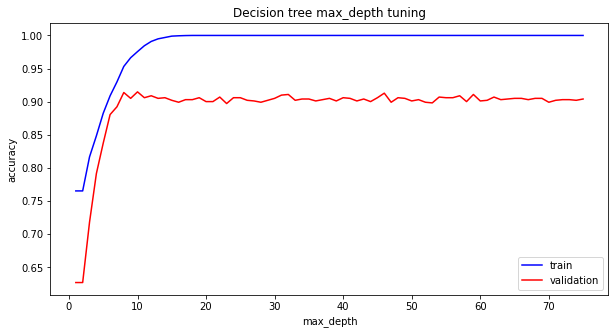

In [78]:
depths = list(range(1, int(np.sqrt(len(X_train)))))
train_scores = []
validation_scores = []

for d in depths:    
    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train, y_train)
    
    # Evaluate
    train_scores.append(dt.score(X_train, y_train))
    validation_scores.append(dt.score(X_validation, y_validation))
    
plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores, c='blue', label='train')
plt.plot(depths, validation_scores, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Decision tree max_depth tuning")
plt.legend()
plt.show()

Max depth =10

After training the model, I completed a hyperparameter optimization and cross-validation for the model, where I used the optimal max depth value of 10 (identified during the hyperparameter optimization) and confirmed the model score to be 88%. So far this has been the most appropriate model for our dataset.

------------------------------------------------------------------------------------------------------------------

### KNN model

K-Nearest Neighbor classifies the outcome by “picking the most common class” amongst the k nearest neighbors. 

In [79]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [80]:
print("K-Nearest Neighbor:")
print(f"Training accuracy: {knn.score(X_train_scaled,y_train)}")
print(f"Validation accuracy: {knn.score(X_val_scaled, y_validation)}")
print(f"Test accuracy: {knn.score(X_test_scaled, y_test)}")

K-Nearest Neighbor:


/opt/anaconda3/envs/Bootcamp/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Training accuracy: 0.5
Validation accuracy: 0.9452054794520548
Test accuracy: 0.9412915851272016


/opt/anaconda3/envs/Bootcamp/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/Bootcamp/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [81]:
k_values = list(range(1, 40, 2))
train_scores = []
validation_scores = []

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train_scaled)
X_validation = scaler.transform(X_val_scaled)

for k in k_values:  
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # Evaluate
    train_scores.append(knn.score(X_train_scaled, y_train))
    validation_scores.append(knn.score(X_val_scaled, y_validation))
 

/opt/anaconda3/envs/Bootcamp/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/Bootcamp/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


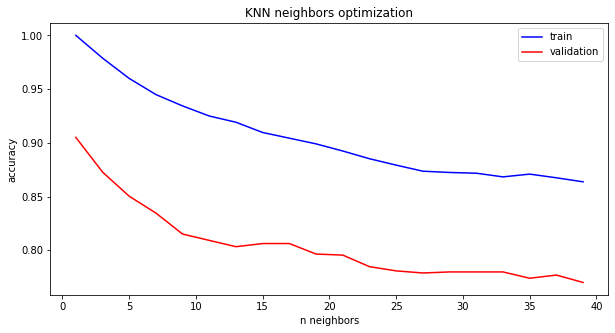

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, train_scores, c='blue', label='train')
plt.plot(k_values, validation_scores, c='red', label='validation')
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.title("KNN neighbors optimization")
plt.legend()
plt.show()

In [83]:
# cheking the optimal k value for the model
best_idx = np.argmin(np.abs(np.array(train_scores) - np.array(validation_scores)))
k_values[best_idx]

33

In [84]:
#refit of the model with the optimal parameters 
scaler = StandardScaler()
scaler.fit(X_train)

X_remainder = scaler.transform(X_train)
X_test = scaler.transform(X_test)

final_dt = KNeighborsClassifier(n_neighbors=25)
final_dt.fit(X_remainder, y_train)

# Score on the test set
print('Final train score:', final_dt.score(X_train, y_train))
print('Final test score:', final_dt.score(X_test, y_test))

/opt/anaconda3/envs/Bootcamp/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Final train score: 0.6035482770385534
Final test score: 0.05870841487279843


After normalizing the model to Standard scaler, and training the model, we carried out a hyperparameter optimization and a cross validation for the model, where I used the optimal K value of 33 (identified during the hyperparameter optimization) and confirmed the model score to be 58%.

------------------------------------------------------------------------------------------------------------------

### Grid Search 

In [85]:
# instantiate model 
estimators = [('normalise', StandardScaler()),
             ('model', LogisticRegression())]  

pipe = Pipeline(estimators)

params = [
        {'model': [LogisticRegression(random_state=1)], 
          'normalise': [StandardScaler(), MinMaxScaler()],
          'model__C': [0.000001,0.00001,0.0001,0.001,0.1,1,10,100],
          'model__solver':['lbfgs', 'liblinear']},
        {'model': [DecisionTreeClassifier()], 
          'normalise': [None],
          'model__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'model__min_samples_leaf': [2, 10]},
        {'model': [KNeighborsClassifier()], 
          'normalise':[StandardScaler(), MinMaxScaler()],
          'model__n_neighbors': [list(range(1, X_train.shape[0]))]},
        {'model': [GaussianNB()], 
          'normalise': [StandardScaler(),None]}  
]

grid_search = GridSearchCV(pipe, param_grid=params, cv=5, verbose= 2)

fitted_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] END model=LogisticRegression(random_state=1), model__C=1e-06, model__solver=lbfgs, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=1e-06, model__solver=lbfgs, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=1e-06, model__solver=lbfgs, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=1e-06, model__solver=lbfgs, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=1e-06, model__solver=lbfgs, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=1e-06, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=1e-06, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.

[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__solver=lbfgs, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__solver=lbfgs, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001

[CV] END model=LogisticRegression(random_state=1), model__C=10, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(random_state=1), model__C=10, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(random_state=1), model__C=10, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(random_state=1), model__C=10, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(random_state=1), model__C=10, model__solver=lbfgs, normalise=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(random_state=1), model__C=10, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=10, model__solver=liblinear, normalise=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(random_state=1), model__C=10, model__solver=

[CV] END model=DecisionTreeClassifier(), model__max_depth=4, model__min_samples_leaf=2, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=4, model__min_samples_leaf=2, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=4, model__min_samples_leaf=10, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=4, model__min_samples_leaf=10, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=4, model__min_samples_leaf=10, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=4, model__min_samples_leaf=10, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=4, model__min_samples_leaf=10, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=5, model__min_samples_leaf=2, normalise=None; total time=   0.0s
[CV] END mo

[CV] END model=KNeighborsClassifier(), model__n_neighbors=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,

[CV] END model=KNeighborsClassifier(), model__n_neighbors=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,

/opt/anaconda3/envs/Bootcamp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Bootcamp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/Bootcamp/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/Bootcamp/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 207, in

In [86]:
fitted_search.best_params_

{'model': DecisionTreeClassifier(max_depth=10, min_samples_leaf=2),
 'model__max_depth': 10,
 'model__min_samples_leaf': 2,
 'normalise': None}

### CONCLUSION

In conclusion, we can observe from the analysis conducted, that from the physical variables, age is correlated to stroke as older individuals suffer more from strokes than younger individuals. However, gender and BMI do not seem to influence the incidence of stroke. When we consider the three medical variables in the dataset, the presence of all 3 (hypertension, heart disease or a higher average glucose level) impacts the incidence of stroke, which shows us to be an invaluable biomarker to consider when predicting which patients are more likely to have a stroke. Lastly, when we explore social variables, we must consider not only their correlation to stroke but the other variables. For instance, marital status (ever married) seems to influence whether a patient will have a stroke. However, we can see that ever married is strongly correlated with age. This shows us that marital status does not necessarily impact whether a patient will have a stroke. However, older individuals are more likely to have ever been married when compared to their younger counterparts, and since age is correlated to stroke, we can interpret that ever married is correlated with age but may not have a direct impact on the risk of a patient having a stroke. This is not true for all social variables (such as smoking status, which formerly smoked is the group with the higher percentage of strokes) but is a factor we need to consider before drawing conclusions. In terms of machine learning models to predict whether a patient will ha a stroke, we can observe that after running a grid search in a pipeline to confirm the results and further exploring the optimal parameters, we confirmed that the Decision Tree Classifier with a max depth of 10, a minimum sample leaf of 2 and no normalization, giving us an accuracy score of 88%, was the most accurate model for the dataset among all four models we explored. 

### NEXT DIRECTIONS

In all, machine learning has great potential to revolutionize medical care by acting as a tool to augment human performance in a healthcare team. AI does not negate healthcare providers' knowledge, observational data nor non-AI related studies. Instead, AI is a tool to take a quicker and more robust approach to diagnostics and the development of therapeutic approaches for stroke recovery. For future directions, one step I would like to explore is deep learning algorithms to not only predict a patient’s likelihood of having a stroke, but also the severity and possible outcomes of stroke. Deep learning algorithms have been gaining quite a bit of attention not only in stroke outcome prediction scenarios but in the medical field. With deep learning, we could map out possible outcomes so we can have a more effective, quicker, and more personalized treatment plan for patients.